# Analyse the quality scores of reads *after* they are mapped

Information about mapped reads is stored within the **S**equence **A**lignment **M**ap file format (SAM). Following the header, each line of a SAM file contains information about a single alignment*. Each line has eleven standardised, tab-separated, fields. See [here](https://en.wikipedia.org/wiki/SAM_(file_format) for a description of each field.

Here, we want to explore how read quality varies *along* a region of the reference genome.


*Note that since in some cases a single read can align multiple times, alignments are different than the number of reads

In [1]:
import os
import sys

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.dpi"] = 150

## Extract alignments within region of interest

We are working with *P.f.* amplicon data in this example. We will focus on the analysis on a single amplicon, *Kelch13*. In order to do this, we will extract only those alignments that fall within the *Kelch13* exon. This can be achieved using `samtools view`:

In [2]:
data_dir = "../data"
bam_fn = "BC01.sorted.bam"  # BAM file containing the alignments of interest
target_bed = "../resources/KELCH13.exons.bed"  # a BED file delineating region of interest
output_sam_fn = "BC01.K13.sam"

In [3]:
cmd = "samtools view %s -L %s -o %s" % (
    os.path.join(data_dir, bam_fn),
    target_bed,
    os.path.join(data_dir, output_sam_fn))

In [4]:
print("Command: %s" % cmd)

Command: samtools view ../data/BC01.sorted.bam -L ../resources/KELCH13.exons.bed -o ../data/BC01.K13.sam


Above shows the samtools command we want to run. We can run this from python using an `os.system()` call:

In [5]:
os.listdir(data_dir) # before command

['BC01.sorted.bam',
 'BC01.K13.sam',
 'BC01.sorted.bam.bai',
 'combined.fastq',
 'FAK66173_9ce70c181767ada48688b5f4e975ccd1e61760e7_1.fastq',
 'FAK66173_9ce70c181767ada48688b5f4e975ccd1e61760e7_0.fastq',
 'FAK66173_9ce70c181767ada48688b5f4e975ccd1e61760e7_2.fastq']

In [6]:
os.system(cmd)

0

In [7]:
os.listdir(data_dir)

['BC01.sorted.bam',
 'BC01.K13.sam',
 'BC01.sorted.bam.bai',
 'combined.fastq',
 'FAK66173_9ce70c181767ada48688b5f4e975ccd1e61760e7_1.fastq',
 'FAK66173_9ce70c181767ada48688b5f4e975ccd1e61760e7_0.fastq',
 'FAK66173_9ce70c181767ada48688b5f4e975ccd1e61760e7_2.fastq']

We have generated the desired SAM file.

## Load SAM file

In [8]:
sam = open(os.path.join(data_dir, output_sam_fn), "r")

In [9]:
sam.readline()

'0b2e2cea-d34e-4a6f-9abe-ce933e82a442\t0\tPf3D7_13_v3\t1724565\t60\t33S37M2D10M1D67M1I28M1D71M1D19M2D11M1D24M1D16M2I12M1I62M2D45M2D7M2D12M2D48M1I73M1D30M2D10M3D43M1I23M1I13M2I29M1I29M1I2M3D16M1D5M2D4M1I8M1D3M1D9M6D6M1I21M3I31M7D3M1I37M1D2M1D10M1D21M5D10M2D12M3D2M1D14M1D8M1D54M1D32M2I24M1I16M1D81M1I15M1I40M2D7M2D39M1D26M1D40M1I27M5D14M2D22M1D5M1D23M1D18M1I23M1I9M1D11M2D9M3D148M2D20M2D4M1D7M1D21M1D14M1I60M1I8M1D14M1I19M1D15M1D9M5D1M1D11M3I132M2D37M2D15M3D17M1I12M1I8M1D11M1I8M1I53M1I15M1I15M1I15M1D9M4D73M1D21M1D33M1D32M1I68M24D50M1D19M2D38M6S\t*\t0\t0\tAGGTTAACACCAAATCTTTTCTTCAGCAGCACCTATAAAGGAAAATCATAAACAATCAAGTAATGTGTATAAAGGTATTTAAAAATAAATTATATATTTATTAATATGTATGTATAATCTTACATATATATATATATATATATATGTATATATATATTTTTTTTTTTTTTTTTATAAAAATGTGCATGAAAATAAATAGTAAAGAAGAAAAATAATATTTTGTGATATATTTGTTATATAAAATTATATATAAAAATAAGAACATTAAATTTCTTCATTTATATATTTGCTATTAAAACAGGTGACCAAATCTGGGAACACTAATAAAGATGGGGCCAAGCTGCCATTCATTTGTATCTGGTGAAAAGAAATGACATGAATTTAGAACTTCGCCTTTCTCCTCCTGTAATTATATAAGAATCTGACAATGTGGCAGCTCAAATT

In [10]:
# the SAM file is tab delineated, we can parse out fields with a split on tab
sam.readline().split("\t")

['00393af0-9176-4381-8ce6-0633dd2dc645',
 '0',
 'Pf3D7_13_v3',
 '1724565',
 '60',
 '5M1D17M1D25M1D66M4D33M3D2M1D22M2D35M4D28M1D17M1D6M1D30M2D3M1D23M1I43M1D34M3D6M1D35M1D90M2D60M2D25M491S',
 '*',
 '0',
 '0',
 'TATAAGGAAAATCATAAACAGTAAGTAATGTGTATAAAAAGGTATTTAAAAATAAATTATATATTTATTAATATGTATGTATAATCTTACATATATATATATATATATGTATATATATATTTTTTTTCTTTTTTTTTATAAAATATTGTAATAAATATTAAAGAAGAAAAAATATTTTGTGATATATTTGTTATATAAGAATATAAAAAATAAGAACATTTAAAATTTCTTCATTTATATATTTGCTATTAAACAGGTGACCAAATCTGGGAACTAATAAAGATGGTAACTGCCATTCATTTGTATCTGGTGAAAAAGAAGTGACGCCAATTTAGAACTTCGCCATTTTCTCATACATAATTATATAAAAATCTGACAATGTAGCAACTCAATTCATCTTTTCTCTGGTACACCATTTAGAAATTGCCATCTTTATTAAATGGTTGATATTGTTCAACGGAATCTAATATGTTATGTTCATTATCAATACCTCCAACAACATATATTTGATTAAGGTAATTAAGCTGCTCCTGAACTTCTAGCTTCTAATAAGGCATATGGAAATTGTTCCCATTTATTCATTTTCTTCATATACTTCAATAGAATATGAAGAAAAAATGGCTCAGGCTAATGCAAAATATATCAAATACTATATTGACAGAAAACAATGATAACTTTACTCTTTATAATAGGCTTCGAACCAGGCTAATCAACCATTTGGCGATGGCTGTTTAAATGACAGCCTGCAGAAAAAGGTGAATTTTGAGCCACGATGAACATAGGAGGAAAAT

## Parsing the CIGAR string

Our goal is to assign each quality score to a position in the genome. If the read was mapped in one continguous region, this would be easy: we could simply align the quality scores with the start position of the read mapping. However, typically there will be many deletions and insertions in the mapping. This is especially true for nanopore data. 

Information about the mapping, including information about insertions or deletions, is stored within the CIGAR string. Briefly, the CIGAR string indicates with a character whether there has been a match "M", an insertion "I", or a deletion "D"; as well as indicating whether the read has been 'clipped' ("S" or "H"). Clipping can occur if, for example, you have limited the the SAM file to reads only present in a particular region. After the character, an integer is given which indicating the length of match, insertion, or deletion. Some examples

- 28M would indicate that there is a match of 28 bases
    - The read and the reference sequence are the same length for this region
- 10D would indicate that there is a *deletion* in the read of 10 bases
    - So the read is *shorter* than the reference genome in this region
- 2I would indicate that there is an *insertion* in the read of 2 bases
    - So the read is *longer* than the reference genome in this region


For complete details see [here](https://samtools.github.io/hts-specs/SAMv1.pdf).

In [11]:
alignment = sam.readline().split("\t")
start = int(alignment[3])
cigar = alignment[5]
quals = alignment[10]

In [12]:
start

1724565

In [13]:
cigar

'35S5M1D7M1D35M2D5M1D59M9D45M1I4M1I33M1I31M1D49M1D18M1D14M1I13M1I20M1I8M2I1M1D11M1D12M1D23M2D7M2D18M1D4M1D10M1I60M1I2M1D24M5D3M1D36M2D7M3D72M1I9M1I100M1I16M1I103M1D5M2I34M1D3M1D11M1D40M1D4M3I6M1I4M4D39M1D34M2D11M1D8M1D15M1D34M2D37M2D32M2D8M1D42M2D46M1I73M2D21M1D25M2D4M1D14M1D4M1D60M1I28M1D56M1I9M1D40M1I55M1D35M1I4M1D17M2I8M2D55M1I11M3D10M1D11M1D6M1D13M1D10M1I28M1D46M1D2M1I28M7D19M1D81M1I3M2D9M1D18M1D10M1D3M1D28M3D33M1D18M1D8M1I13M2I58M1D10M1D7M1D9M1I34M1D6M1D77M1D15M23D17M6D6M1D21M1D25M1I31M'

Now what we need to do is produce a vector of positions for each quality score, using the start position and cigar string. The basic approach is:

- If there is a match, the positions increment one base at a time
- If there is a insertion in the read, those positions in the read are *not* in the reference genome
    - Give them an invalid value (-999)
- If there is a deletion in the read, we pass
    - We are effectively skipping positions
- If there is a soft-clip, those positions in the read are *not* in the target region
    - Give them an invalid value (-998)
- If there is a hard-clip, we pass

An important detail to note here is that all the alignments within the SAM file are represented with respect to the *forward* strand. Those reads that mapped to the reverse strand are reverse-complimented before being stored in the SAM file.

In [14]:
pos = []
i = start
tags = re.findall("\d*[MIDSH]", cigar)  # parse the cigar string into 'tags'
for tag in tags:
    n = int(tag[:-1]) # this is the integer value of the tag
    m = tag[-1] # this is the 'm'ethod: M, D, I, S, H ...
    if m == 'M':  # match
        pos.extend(np.arange(i, i + n))
    elif m == "I":  # insertion
        pos.extend(np.repeat(-999, n))
    elif m == "D":  # deletion
        pass
    elif m == "S":  # clip
        pos.extend(np.repeat(-998, n))
    elif m == "H":
        pass
    else:
        Print("Tag %s not identified." % m)
    i += n  # we have moved forward n positions
pos = np.array(pos) # convert to an array at the end

In [15]:
print("Length of positions: %d" % len(pos))
print("Length of quality scores: %d" % len(quals))

Length of positions: 2580
Length of quality scores: 2580


Good. Now let's convert the quality scores to error probabilities...

In [16]:
qs = np.array([ord(c) - 33 for c in quals])
error_probs = 10 ** (qs / -10)

In [17]:
error_probs

array([0.06309573, 0.12589254, 0.03162278, ..., 0.1       , 0.02511886,
       0.00398107])

Let's plot the results for this read...

Text(0,1,'Single-read error probabilities mapped to $K13$')

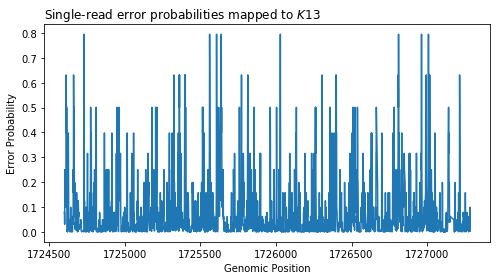

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(pos[pos > 0], error_probs[pos > 0])
ax.set_xlabel("Genomic Position")
ax.set_ylabel("Error Probability")
ax.set_title("Single-read error probabilities mapped to $K13$", loc='left')

## Generalising

Now all we need to do is expand this to handle the complete SAM file. For this we will build some functions.

In [19]:
def positional_error_from_sam(sam_path):
    """
    Extract error probabilities and their positions
    from a SAM file
    
    params
        sam_path : str
            Path to SAM file.
            
    returns
        positions : list of ndarray, int, shape(n_reads, )
            List of numpy arrays. Each array
            encodes positions of aligned bases
            for a read. Note that -998 indicates clipped,
            -999 indicates deletion.
        error_probs : list of ndarray, float, shape(n_reads, )
            List of numpy arrays. Each array
            encodes error probabilities aligned bases
            for a read.
    
    """
    # Open SAM
    with open(sam_path, "r") as sam:

        # Prepare storage
        positions = []
        error_probs = []

        for alignment in sam:
            # Parse alignment & get relevant fields
            fields = alignment.split("\t")
            start = int(fields[3])
            cigar = fields[5]
            quals = fields[10]

            # Compute
            alignment_error_probs = calc_error_probabilities(quals)
            alignment_positions = get_positions_from_cigar(start, cigar)

            # Store
            positions.append(alignment_positions)
            error_probs.append(alignment_error_probs)
            
    return positions, error_probs

In [20]:
def calc_error_probabilities(quals):
    """
    Calculate error probabilities from
    a string of ASCII characters `quals` that
    encode error probabilities
    
    params
        quals : str
            Error probabilities encoded in ASCII.
    
    returns
        error_probs : ndarray, float, shape(read_length, )
            Error probabilities in a
            numpy array.
    
    """
    qs = np.array([ord(c) for c in quals]) - 33
    error_probs = 10 ** (qs / -10)
    return error_probs

In [21]:
def get_positions_from_cigar(start, cigar):
    """
    Get alignment positions for each base in a read
    given a `start` position and a `cigar` string
    
    params
        start : int
            The start position of the aligment.
        cigar : str
            The CIGAR string for the alignment.
    
    returns
        pos : ndarray, int, shape (read_length,)
            A genomic position for each base in the
            read.
    
    """
    pos = []
    i = start
    tags = re.findall("\d*[MIDSH]", cigar)  # parse the cigar string into 'tags'
    
    for tag in tags:
        n = int(tag[:-1]) # this is the integer value of the tag
        m = tag[-1] # this is the 'm'ethod: M, D, I, S, H ...
        if m == 'M':  # match
            pos.extend(np.arange(i, i + n))
        elif m == "I":  # insertion
            pos.extend(np.repeat(-999, n))
        elif m == "D":  # deletion
            pass
        elif m == "S":  # clip
            pos.extend(np.repeat(-998, n))
        elif m == "H":
            pass
        else:
            Print("Tag %s not identified." % m)
        i += n  # we have moved forward n positions
    
    return np.array(pos)

In [22]:
sam_path = os.path.join(data_dir, output_sam_fn)
positions, error_probs = positional_error_from_sam(sam_path)

In [23]:
# The number of reads...
len(positions)

348

In [24]:
len(error_probs)

348

## Munge and visualise results

In [25]:
positions = np.concatenate(positions)
error_probs = np.concatenate(error_probs)

In [26]:
keep = positions > 0
positions = positions[keep]
error_probs = error_probs[keep]

In [27]:
len(positions)
# 776 thousand bases have a quality score

776572

In [28]:
df = (pd.DataFrame({"position": positions, "error_prob": error_probs})
      .groupby("position")
      .mean()
      .reset_index()
      .sort_values("position")
     )

In [29]:
df.head() # mean error probabilities at each position

,position,error_prob
0,1724565,0.025119
1,1724566,0.103764
2,1724567,0.071243
3,1724568,0.059930
4,1724569,0.065843


Text(0,1,'Mean Error Probability Across $Kelch13$')

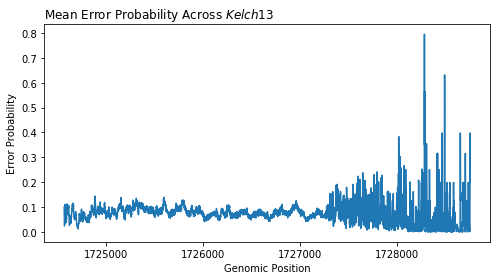

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(df["position"], df["error_prob"])
ax.set_xlabel("Genomic Position")
ax.set_ylabel("Error Probability")
ax.set_title("Mean Error Probability Across $Kelch13$", loc="left")

- Looks like more error at one end.. less coverage there perhaps?

In [31]:
df["coverage"] = (pd.DataFrame({"position": positions, "error_prob": error_probs})
                  .groupby("position")
                  .size()
                  .values
                 )

In [32]:
df.head()

,position,error_prob,coverage
0,1724565,0.025119,1
1,1724566,0.103764,6
2,1724567,0.071243,10
3,1724568,0.059930,114
4,1724569,0.065843,130


Text(0,0.5,'Coverage')

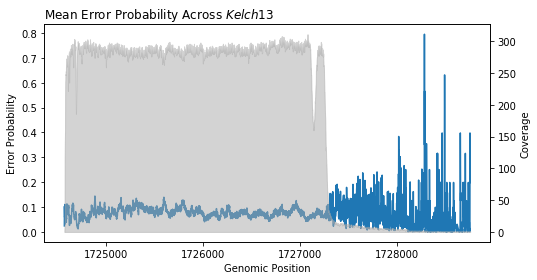

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(df["position"], df["error_prob"])
ax.set_xlabel("Genomic Position")
ax.set_ylabel("Error Probability")
ax.set_title("Mean Error Probability Across $Kelch13$", loc="left")

axm = ax.twinx()
axm.fill_between(x=df["position"],
                 y1=np.repeat(0, df.shape[0]),
                 y2=df["coverage"],
                 color='darkgrey', alpha=0.5)
axm.set_ylabel("Coverage")

- Result seems to be explain by a decline in coverage
- Would be interesting to indicate primer positions and gene body